In [312]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve , generate_binary_structure

In [313]:
N= 30

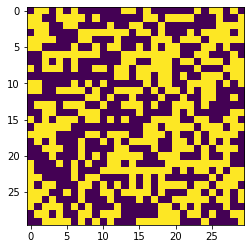

In [314]:
def create_configuration(N):
    init_state = 2.0*np.random.randint(0,2, size=(N,N)) - 1
    return init_state

initial_state = create_configuration(N)
type(initial_state)
plt.imshow(initial_state) 

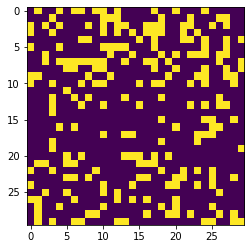

In [315]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1
plt.imshow(lattice_n)

In [316]:
def total_energy(lattice):
    kernel = generate_binary_structure(2,1)
    kernel[1][1] = False
    arr = -lattice*convolve(lattice, kernel, mode='constant', cval=0)
    return arr.sum()

total_energy(initial_state)

-8.0

In [317]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, n_iter, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(n_iter-1)
    net_energy = np.zeros(n_iter-1)
    for n in range(0, n_iter-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]

        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]

        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
       
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0) and (np.exp(-BJ*dE) > np.random.random()):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[n] = spin_arr.sum()
        net_energy[n] = energy
            
    return net_spins, net_energy

c:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [318]:
spins, energies = metropolis(lattice_n, 1000000, 0.8, total_energy(initial_state))
print(spins)

[-454. -454. -454. ... -886. -886. -886.]


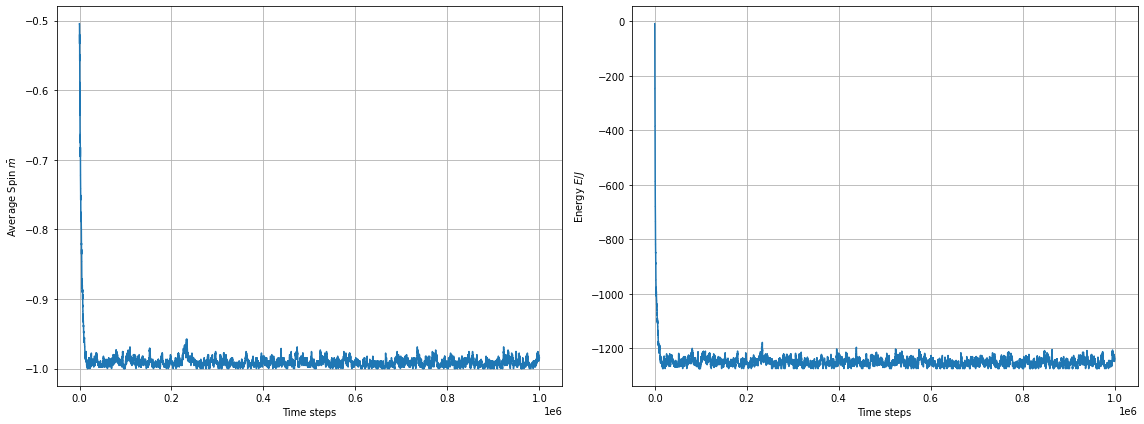

In [319]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel("Time steps")
ax.set_ylabel(r"Average Spin $\bar{m}$")
ax.grid()

ax = axes[1]
ax.plot(energies)
ax.set_xlabel("Time steps")
ax.set_ylabel(r"Energy $E/J$")
ax.grid()

fig.tight_layout()